In [1]:
import numpy as np

# Evaluation metrics

In this lab you will learn different metrics, how they are computed and how they can be analysed.

We will apply each of the metrics to classification with the histogram comparison method.

In [2]:
from lib.soda_dataset import get_gallery_and_queries
from lib.histogram_comparison import match_opp_color_hist

# Create our gallery and queries
gallery, queries, gallery_labels, true_labels = get_gallery_and_queries()

# Compute the similarity matrix
sim_mat = match_opp_color_hist(gallery, queries)

# Find the best match index for each query
match_idxs = sim_mat.argmax(axis=1)

# Map the match indices to labels
pred_labels = gallery_labels[match_idxs]

## Accuracy

The **accuracy** determines what fraction of all predictions were correct. It is defined as:

$$\text{accuracy} = \frac{\text{Number of correct predictions}}{\text{Number of predictions}}$$

A prediction is correct when the true label and the predicted label are the same. The accuracy is often used to assess the performance of a classification model.

However, the accuracy metric ignores all information about the specific class labels, it only checks whether or not the predicted is the same as the true label. For example, we do not know if there are any classes that are misclassified very often.

In [3]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=true_labels,
                     y_pred=pred_labels)
print('The accuracy is {acc:.2f}%'.format(acc=acc*100))

The accuracy is 62.50%


### Confusion matrix

The accuracy does not say anything about the performance on specific classes. A **confusion matrix**, on the other hand, summarizes correct and wrong classifications nicely for each class.

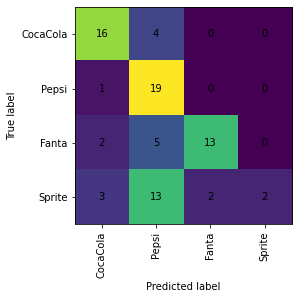

In [4]:
from sklearn.metrics import confusion_matrix

from lib.plots import plot_conf_mat


cmat = confusion_matrix(y_true=true_labels,
                        y_pred=pred_labels,
                        labels=gallery_labels)

plot_conf_mat(cmat, gallery_labels)

The **rows correspond to the true label**, while the **columns correspond to the predicted label**. As such, the diagonal contains all correct predictions.

For a given label *A*, there are two ways for a query to be correctly classified and two ways for it to be wrongly classified:

Correctly classified:

1. **True positive** (TP) of label *A*: the query is predicted to have label *A* and indeed has label *A*
2. **True negative** (TN) of label *A*: the query is predicted to *not* have label *A* and indeed does not have label *A*

Wrongly classified:

1. **False positive** (FP) of label *A*: the query is predicted to have label *A*, but *does not* have label *A*
2. **False negative** (FN) of label *A*: the query is predicted to *not* have label *A*, but *does* have label *A*

For each label in the dataset, we can compute the number of TP, TN, FP and FN. This will give us a much more detailed idea of how well our classifier works for each label in the dataset.

The number of TPs, TNs, FPs and FNs of each label in the dataset, can be computed from the confusion matrix. Let's say that label *A* corresponds to row *i* and column *i* of the confusion matrix. Then check for yourself that:

* The number of **TPs** of label *A* is the value at **cell $(i, i)$** of the confusion matrix
* The number of **TNs** of label *A* is the sum of the cells that are **not in row $i$, nor in column $i$**
* The number of **FPs** of label *A* is the sum of the cells in **column $i$, excluding cell $(i, i)$**
* The number of **FNs** of label *A* is the sum of the cells in **row $i$, excluding cell $(i, i)$**

In [5]:
from lib.evaluation_metrics import calc_tp_tn_fp_fn

print(f'{"Label":<15}|{"TP":^5}|{"TN":^5}|{"FP":^5}|{"FN":^5}')
print(f'{"-"*15}|{"-"*5}|{"-"*5}|{"-"*5}|{"-"*5}')

for label in gallery_labels:
    tp, tn, fp, fn = calc_tp_tn_fp_fn(label, cmat, gallery_labels)
    print(f'{label:<15}|{tp:^5}|{tn:^5}|{fp:^5}|{fn:^5}')

Label          | TP  | TN  | FP  | FN  
---------------|-----|-----|-----|-----
CocaCola       | 16  | 54  |  6  |  4  
Pepsi          | 19  | 38  | 22  |  1  
Fanta          | 13  | 58  |  2  |  7  
Sprite         |  2  | 60  |  0  | 18  


### Precision and recall

The number of TPs, FPs, FNs and TNs of a certain label are often summarized with the **precision** and **recall**. These are defined as:

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

where $\text{TP}$ is the number of true positives and $\text{FP}$ is the number of false positives of the label. For a given class *A*, the precision can be interpreted as **the fraction of queries that truly belong to class *A* when our model said they belonged to class *A***.

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

where $\text{TP}$ is the number of true positives and $\text{FN}$ is the number of false negatives.  For a given class *A*, the recall can be interpreted as **the fraction of all queries with class *A* that that our classifier was able to retrieve**.

Depending on the application, a high precision might be more important than a high recall or vice versa.

Since precision and recall are computed with TPs, FPs and FNs, they can also be directly computed from the confusion matrix. Let's say that label *A* corresponds to row *i* and column *i* of the confusion matrix. Then check for yourself that:

* **Precision** is the value at **cell $(i, i)$** divided by the sum of the cells in **column $i$**
* **Recall** is the value at **cell $(i, i)$** divided by the sum of the cells in **row $i$**

In [6]:
from lib.evaluation_metrics import calc_precision, calc_recall

precisions = [
    calc_precision(label, cmat, gallery_labels)
    for label in gallery_labels
]

recalls = [
    calc_recall(label, cmat, gallery_labels)
    for label in gallery_labels
]

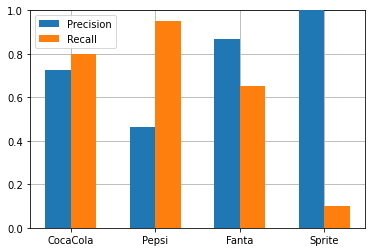

In [7]:
import matplotlib.pyplot as plt

N_LABELS = len(gallery_labels)
x = np.arange(N_LABELS)
width = 0.3

fig, ax = plt.subplots()
ax.grid(zorder=0)
ax.set_xticks(x)
ax.set_xticklabels(gallery_labels)
ax.set_ylim([0, 1])

# Plot precisions
ax.bar(x=x - width/2, height=precisions, label='Precision',
       width=width, zorder=3)

# Plot recalls
ax.bar(x=x + width/2, height=recalls,label='Recall',
       width=width, zorder=3)

# Add legend
ax.legend();

## PR-curve

Up until now, we evaluate our model by looking at which label matches best with a query, according to our model. We do not take into account the similarity score that is assigned by the model. However, by thresholding that similarity value, we might increase the precision of the model (albeit at the cost of a lower recall). For each such thresholding value, we can recompute precision and recall. When plotting all these precision-recall pairs, we obtain the **precision-recall curve**.

A PR curve shows how the precision and recall vary for different threshold values. When the curve reaches the top right point of the graph, there exists a threshold for which the classifier works perfectly for the corresponding class.

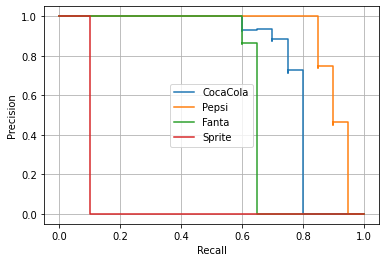

In [8]:
from lib.evaluation_metrics import calc_pr_curve


fig, ax = plt.subplots()

for label in gallery_labels:
    p, r, _ = calc_pr_curve(label, sim_mat, gallery_labels, true_labels)

    # Add (1.0, 0.0) for nicer visualization
    p = np.array([0, *p])
    r = np.array([1, *r])

    ax.plot(r, p, label=label, drawstyle="steps-post")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

ax.grid()
ax.legend();

### Average Precision

To summarize the PR-curve, we can compute the **average precision**, which is the integral of the PR-curve.

$$
\text{AP} = \sum_{t} P_{t}\cdot (R_{t} - R_{t-1})
$$

with $P_t$ and $R_{t}$ the precision, resp. recall, at threshold $t$ ($R_0$ is defined as 1).

Intuitively, the AP measures how well our algorithm sorted the query items from most to least similar to a given class.

In [9]:
from lib.evaluation_metrics import calc_ap

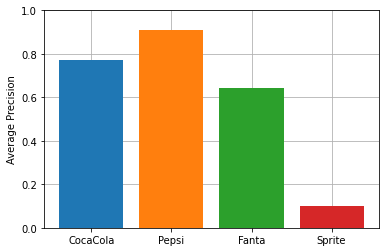

In [10]:
fig, ax = plt.subplots()
ax.grid(zorder=0)
ax.set_ylim([0, 1])

for label in gallery_labels:
    ap = calc_ap(label, sim_mat, gallery_labels, true_labels)
    ax.bar(label, ap, zorder=3)
    ax.set_ylabel('Average Precision')